# Problem Definition

Use historical boxscores to predict an NBA player's Turnovers Per Second (TPS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total turnovers of a player in a single game.

### Usage

- The final turnover projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Factor Determination
Determine the factors that influence a player's Turnovers Per Second (TPS).

- Historical TPS
    - Season averages
    - Recent performances
    - Home vs. Away
    - Start vs. Bench
    - Rest


- Defense
    - Opponent TPS Allowed
        - Starters vs. Bench Players
        - By position
    - Vegas implied total points

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

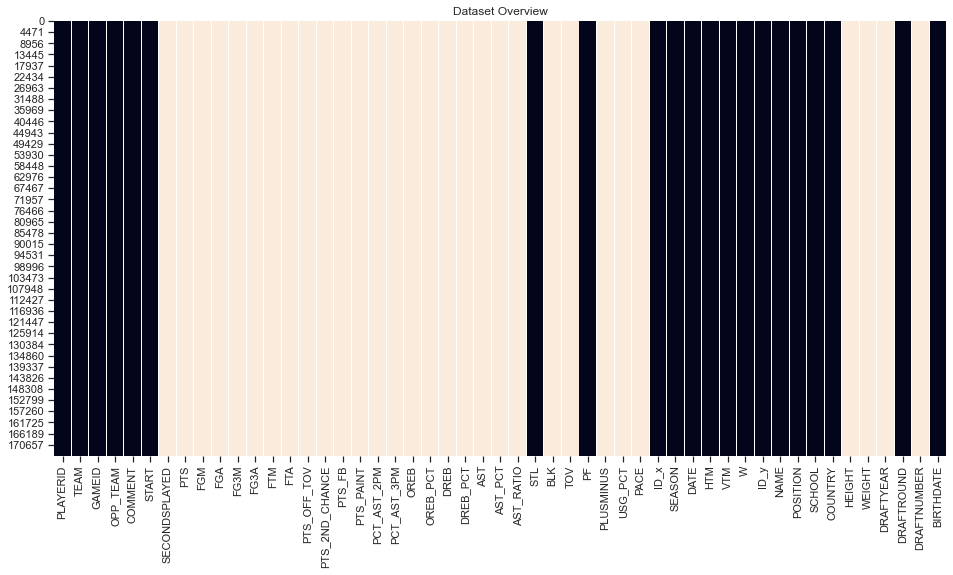

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $TPS$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['TOV']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

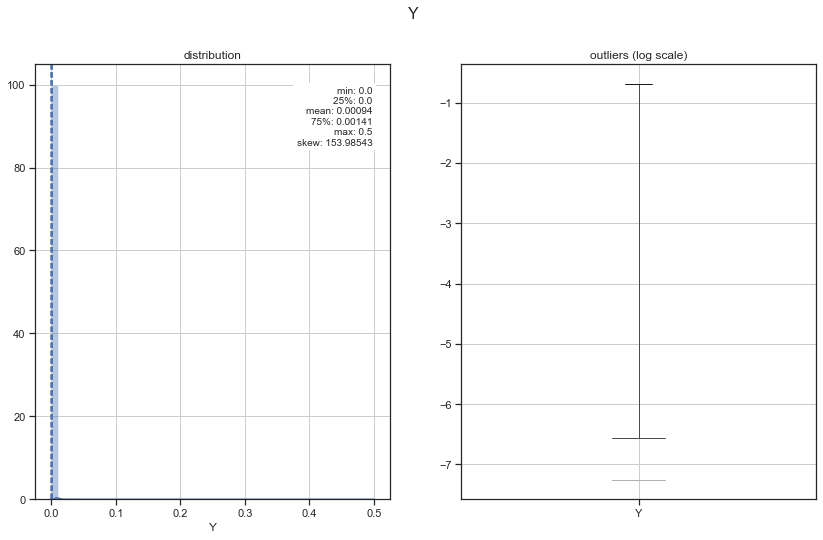

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 6 seconds, and gave up 1 turnover, his $TPS$ would be 0.167. That would be an outlier in our distribtion.

Below shows the $TPS$ distribution across different playing times.

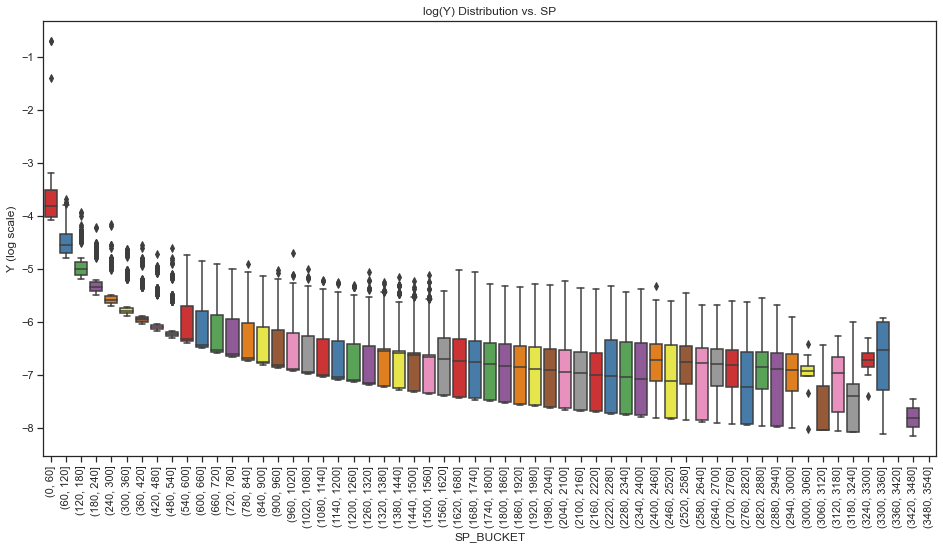

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

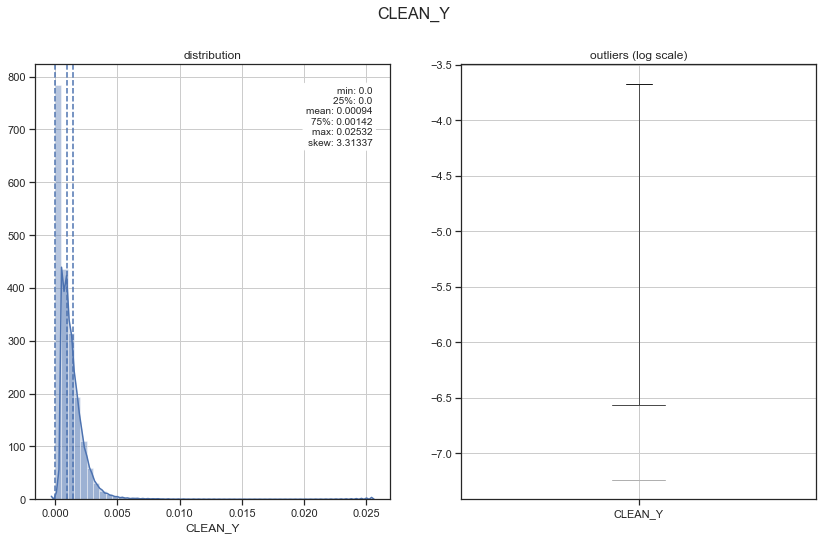

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

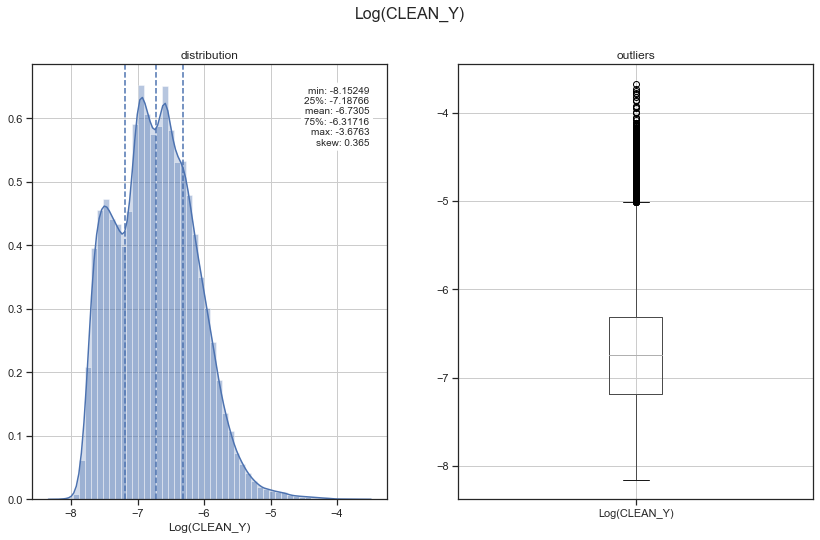

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9831006526947021 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical TPS
First, I will create features that represent a player's historical $TPS$.

I will start by calculating the running $TPS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y'
)

regressors.append('AVG_Y')

Next, I will calculate the average $TPS$ of a player in the previous games against the same opposing team in the same season.

In [12]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)

regressors.append('AVG_Y_OPP_TEAM')

Do more recent turnover performances within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation between a player's $TPS$ and his previous $TPS$ values:

$$ ACF(X_{0}, X_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between between a player's $TPS$ and his previous $TPS$ values, using the lags in between as covariates:

$$ PACF(X_{0}, X_{i}  |  \{X_{j}\}_{0<j<i}) $$ <br>

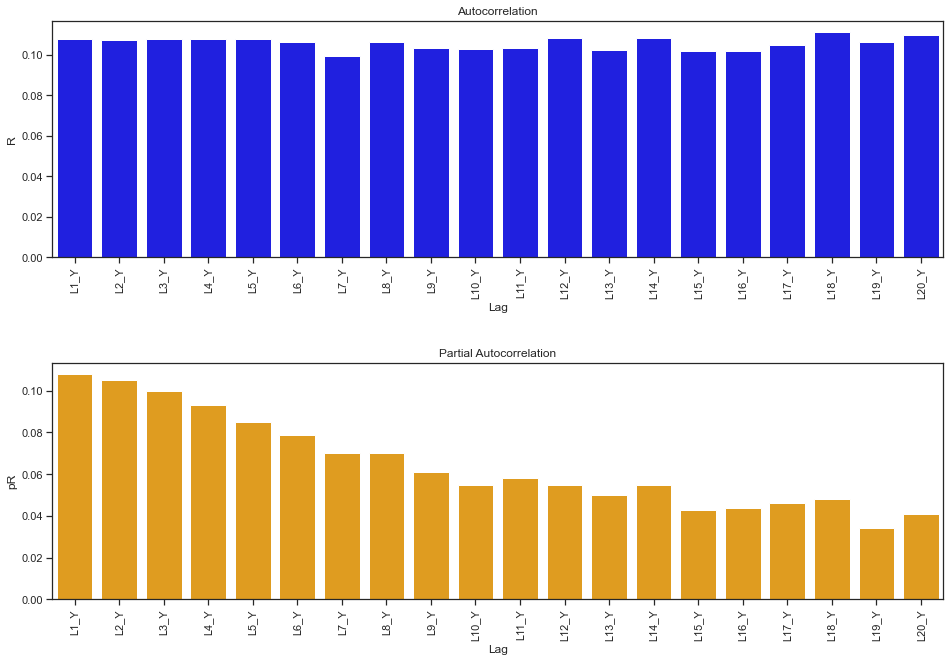

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

x_ticks = []
corrs = []
p_corrs = []
for i in range(1, 21):
    x = 'L{}_{}'.format(str(i), y)

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=clean_y, new_col_name=x, n_shift=i
    )
    
    corr = boxscores[clean_y].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=x_ticks)
    
    corrs.append(corr)
    p_corrs.append(p_corr['r'][0])
    x_ticks.append(x)
    
corr_df = pd.DataFrame({'R': corrs, 'pR': p_corrs, 'Lag': x_ticks})

sns.barplot(x='Lag', y='R', data=corr_df, color='blue', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('Autocorrelation')

sns.barplot(x='Lag', y='pR', data=corr_df, color='orange', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $TPS$ and each $TPS_{i}$ is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $X_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lags to our list of regressors. It also makes the case that an exponentially weighted mean of previous lags may be more predictive than a normal mean.

In [14]:
regressors.append('L1_Y')

boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='EWM_Y', alpha=0.90
)

regressors.append('EWM_Y')

Next, I will calculate the partial correlation between $TPS$ and previous moveing averages of $TPS$, using a covariate of the AVG_$TPS$. The peak of this graph will tell us which MA provides the most new information on top of the average.

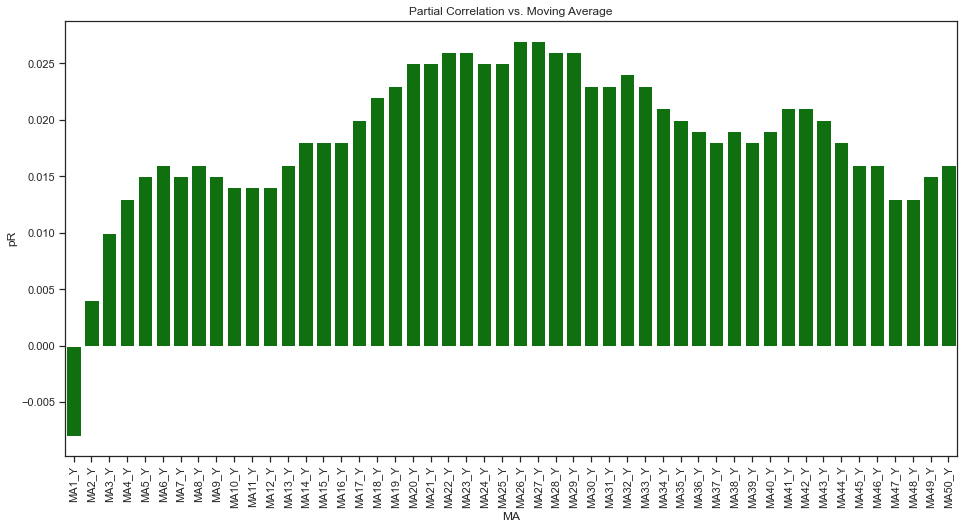

In [15]:
x_ticks = []
p_corrs = []
for i in range(1, 51):
    x = 'MA{}_{}'.format(str(i), y)

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=['AVG_Y'])
    
    x_ticks.append(x)
    p_corrs.append(p_corr['r'][0])
    
corr_df = pd.DataFrame({'pR': p_corrs, 'MA': x_ticks})
ax = sns.barplot(x='MA', y='pR', data=corr_df, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Partial Correlation vs. Moving Average')
plt.show()
plt.close()

I will use MA6_$TPS$ and MA26_$TPS$.

In [16]:
regressors.append('MA6_Y')
regressors.append('MA26_Y')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

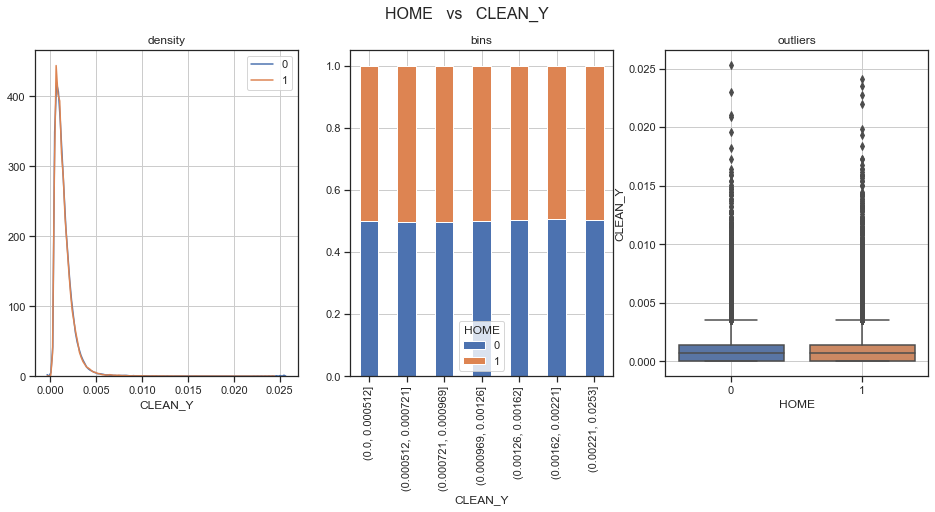

In [17]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $TPS$.

Next I will determine if a player's $TPS$ depends on his status as a Starter.

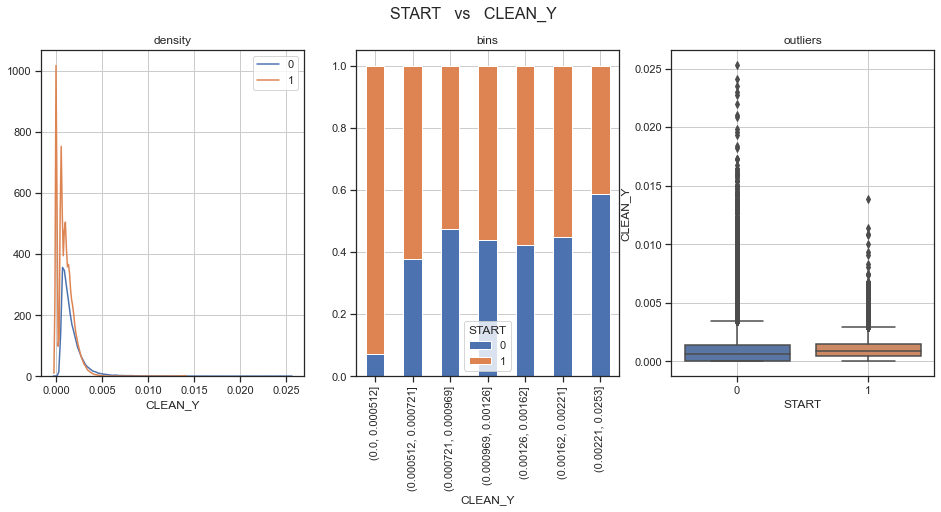

In [18]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $TPS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $TPS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [19]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 32
Percentage of significant (season, player) combinations: 0.018038331454340473


The percentage of (season, player) combinations that exibit a significant difference is 1.80%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $TPS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [20]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $TPS$.

In [21]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

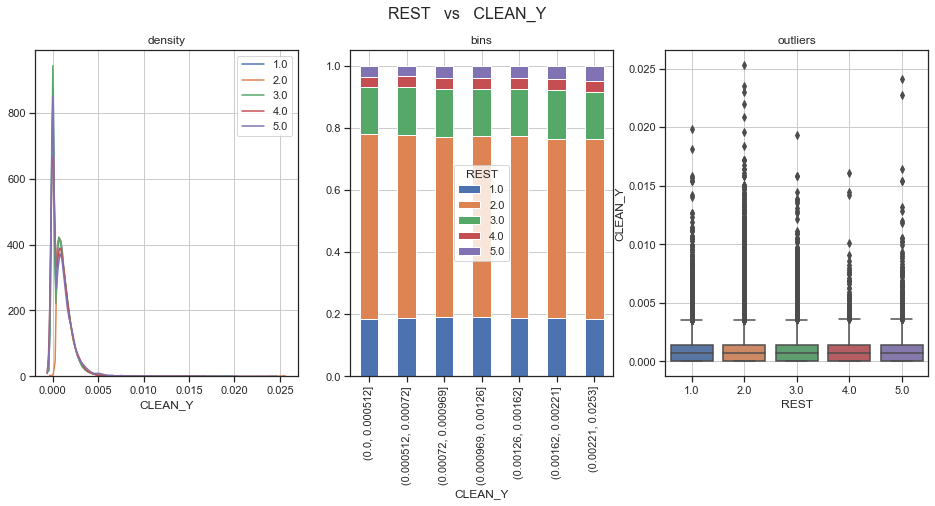

In [22]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

### Defense
Next, I will create features based on the defense of the opposing team.

First, I will calculate the turnover defense of each team on a game-to-game basis. I will define three metrics to measure turnover defense:

$$TEAM\_Y\_DIFF\_ALLOWED =  TEAM\_Y\_ALLOWED - TEAM\_Y\_AVG$$

where $TEAM\_Y\_ALLOWED$ is the $TPS$ allowed to the opposing team and $TEAM\_Y\_AVG$ is the $TPS$ of that team throughout the season coming into the game.

In [23]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='TOV', new_col_name='AVG_TOV'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['TOV', 'SECONDSPLAYED', 'AVG_TOV', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED': x['TOV'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG': x['AVG_TOV'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED'] - grouped_defensive_boxscores['TEAM_Y_AVG']

Next, I will visualize the defense of each team for each season in the dataset. I will also run a one-way ANOVA test to determine if the mean $TEAM\_Y\_DIFF\_ALLOWED$ differs among the teams in each season.

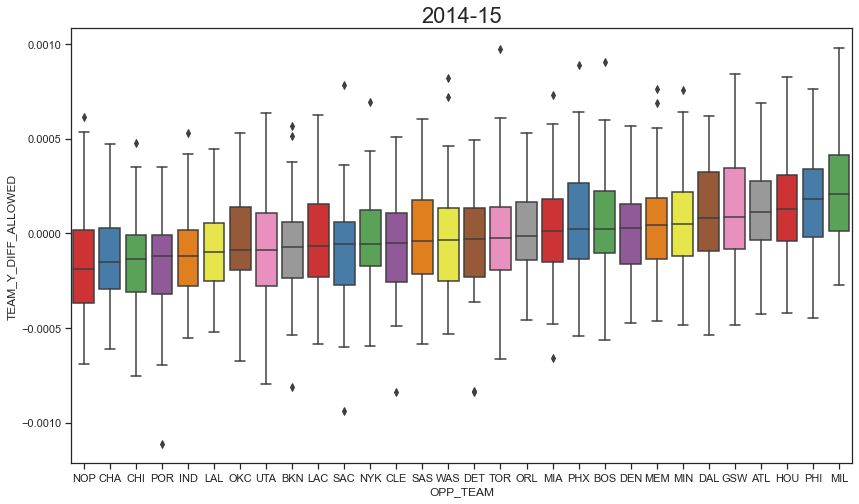

Team defenses are statistically siginficantly different


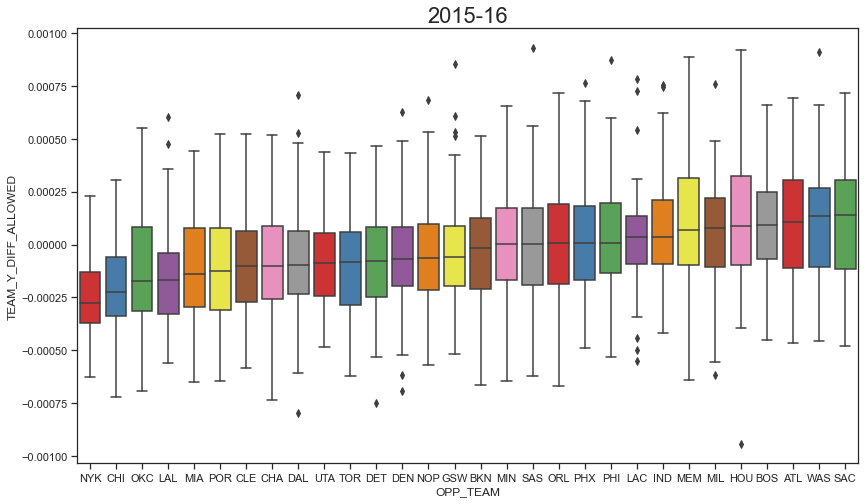

Team defenses are statistically siginficantly different


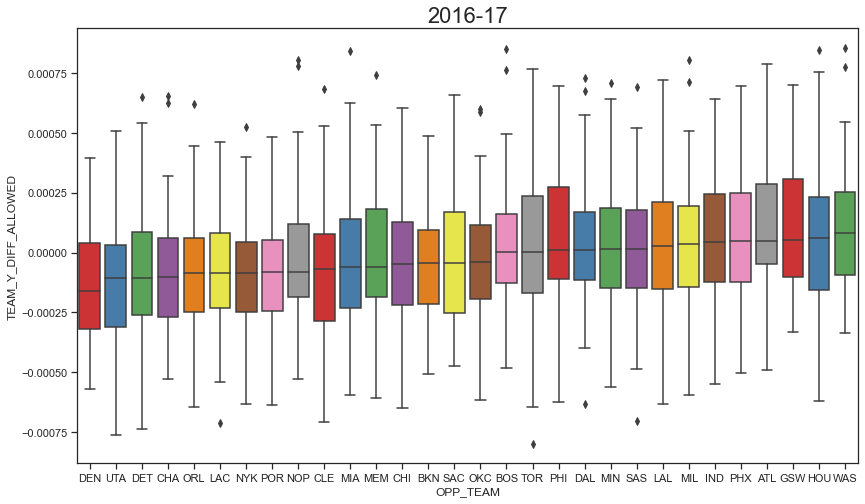

Team defenses are statistically siginficantly different


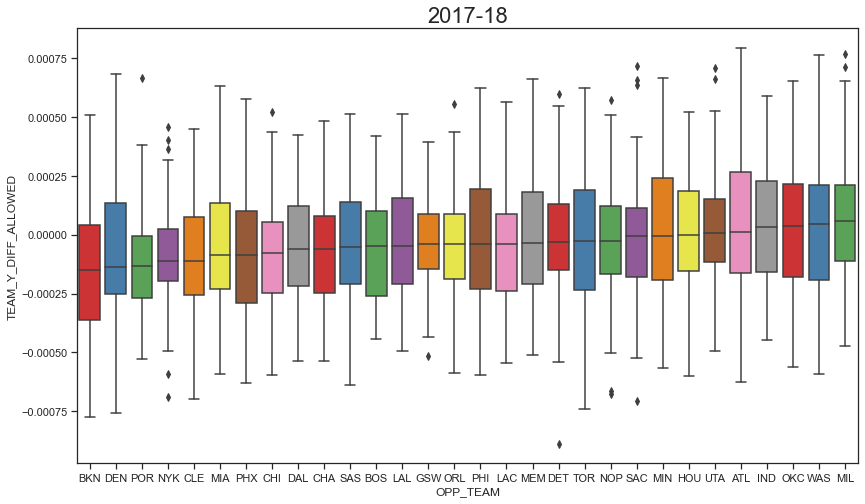

Team defenses are statistically siginficantly different


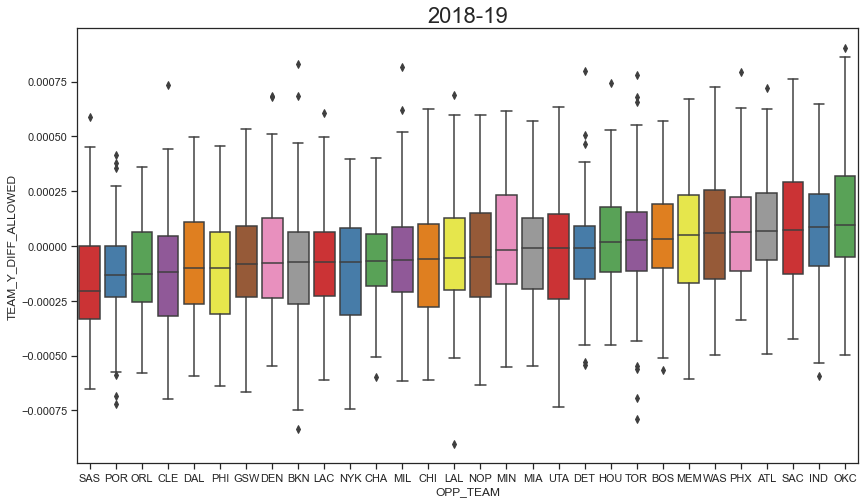

Team defenses are statistically siginficantly different


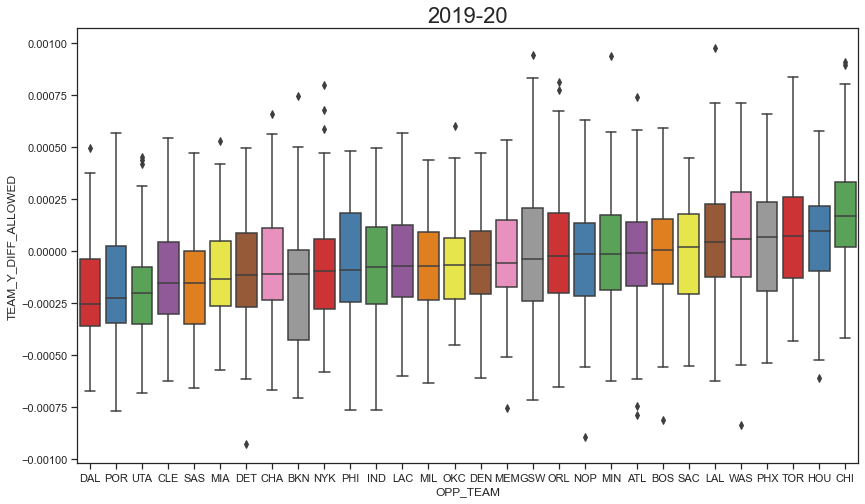

Team defenses are statistically siginficantly different


In [24]:
a = 0.01
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    plt.figure(figsize=(14, 8))
    plt.title(season,fontsize=22)
    opp_team_def = [
        (opp_team, temp2['TEAM_Y_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    opp_team_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in opp_team_def]
    sns.boxplot(x="OPP_TEAM", y="TEAM_Y_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams)
    
    plt.show()
    plt.close()
    
    anova = pg.anova(dv='TEAM_Y_DIFF_ALLOWED', between='OPP_TEAM', data=temp, detailed=True)
    p = anova['p-unc'].iloc[0]
    if p < a:
        print('Team defenses are statistically siginficantly different')
    else:
        print('Team defenses are not statistically siginficantly different')

Now, I will calculate the average turnover defense of the opposing team across all previous games in a season, $AVG\_TEAM\_Y\_DIFF\_ALLOWED$.

In [25]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_Y_DIFF_ALLOWED', new_col_name='AVG_TEAM_Y_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

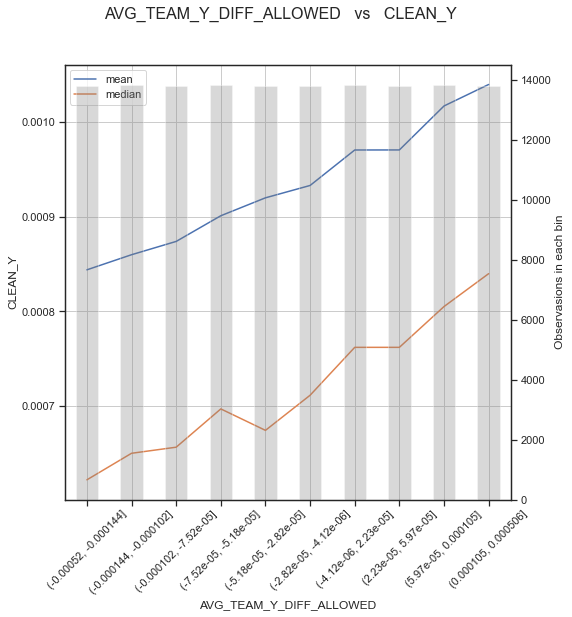

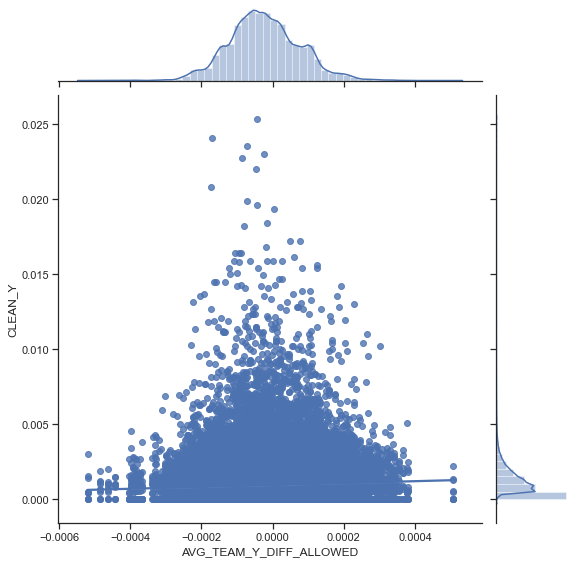

In [26]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED', clean_y, figsize=(8, 8))

In [27]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED')

The metrics above track the opposing team's turnover defense on all players. However, an opposing team's turnover defense may differ among starts and bench players, as each set will have a mostly different group of opposing players.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_P$ to quantify a team's turnover defense on opposing players by role (guard/forward/center).

In [28]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['TOV', 'SECONDSPLAYED', 'AVG_TOV', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_P': x['TOV'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_P': x['AVG_TOV'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_Y_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='TEAM_Y_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

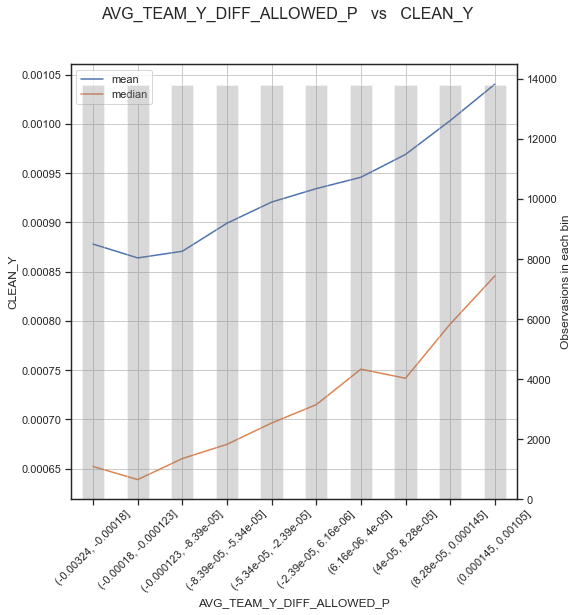

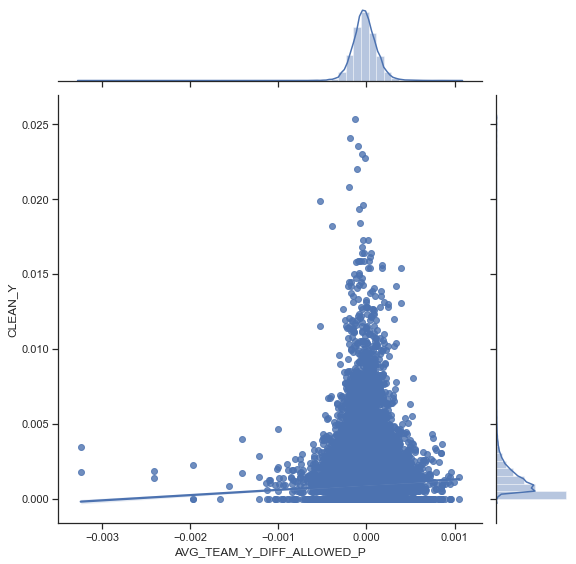

In [29]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_P', clean_y, figsize=(8, 8))

In [30]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_P')

I will also include the vegas implied game point total as a feature.

In [31]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [32]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

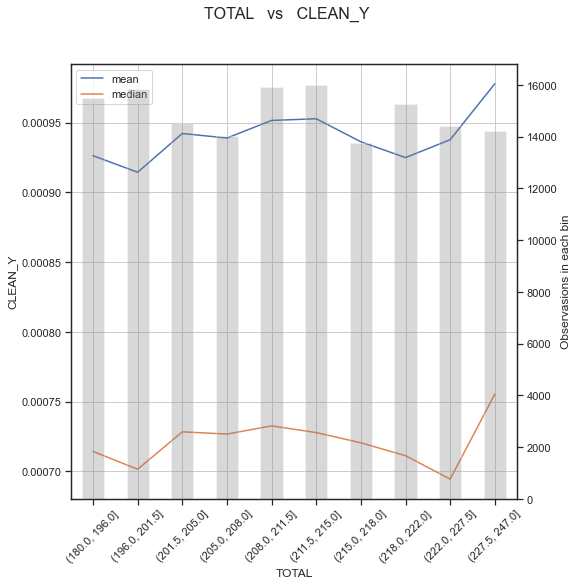

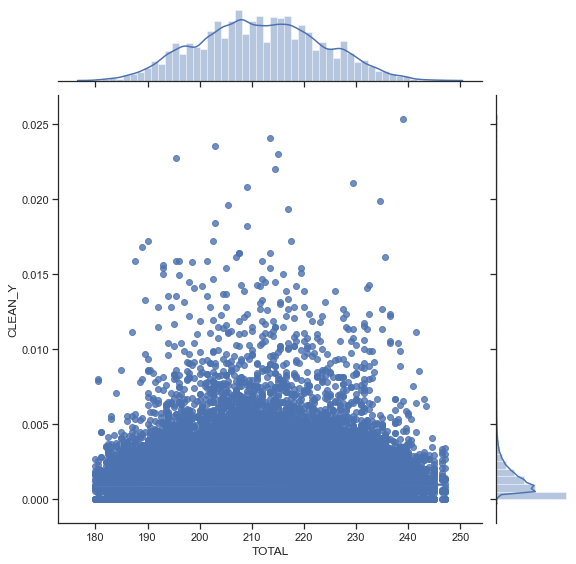

In [33]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [34]:
regressors.append('TOTAL')

### Weights
Lastly, I will add a column to weight each $Y$ value. I do not care about each occurance of the dependant variable equally; the $TPS$ of a player who gives up 1 turnover in 180 seconds should not be weighted the same as the $TPS$ of a plyer who gives up 10 turnovers in 1800 seconds. 

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

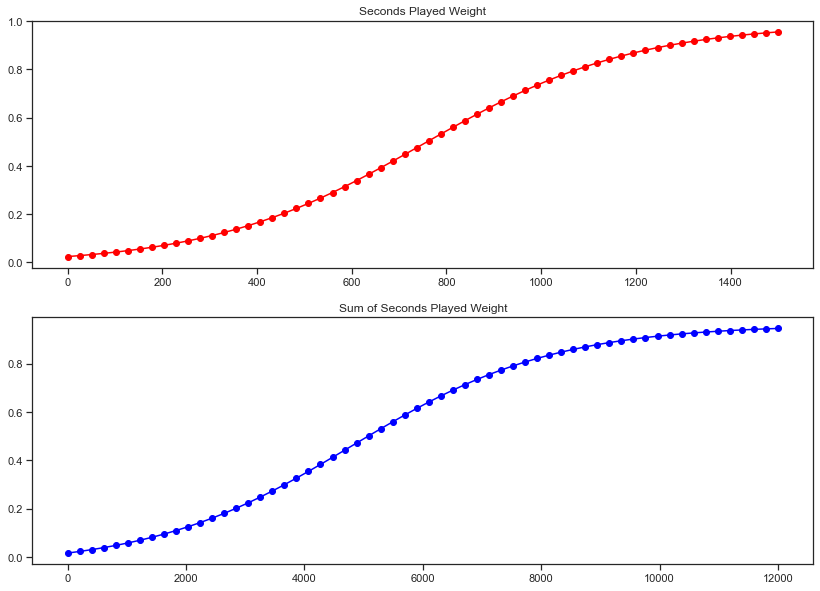

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [36]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [37]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')


regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

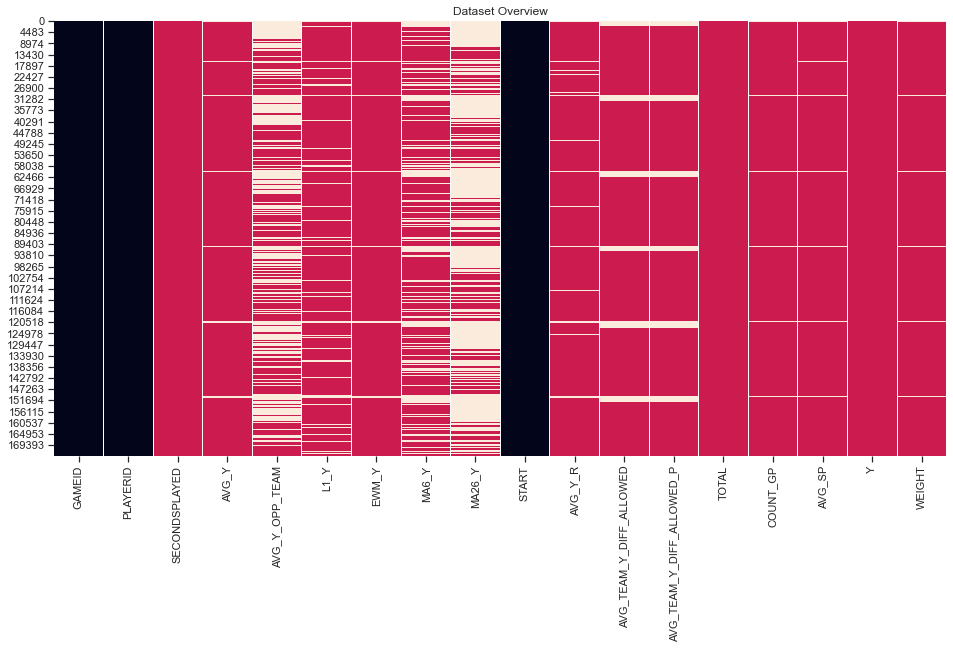

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 68.868


In [38]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [39]:
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])

feature_matrix['L1_Y'] = feature_matrix['L1_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['EWM_Y'] = feature_matrix['EWM_Y'].fillna(feature_matrix['AVG_Y'])

feature_matrix['MA6_Y'] = feature_matrix['MA6_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA26_Y'] = feature_matrix['MA26_Y'].fillna(feature_matrix['MA6_Y'])

feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])

feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

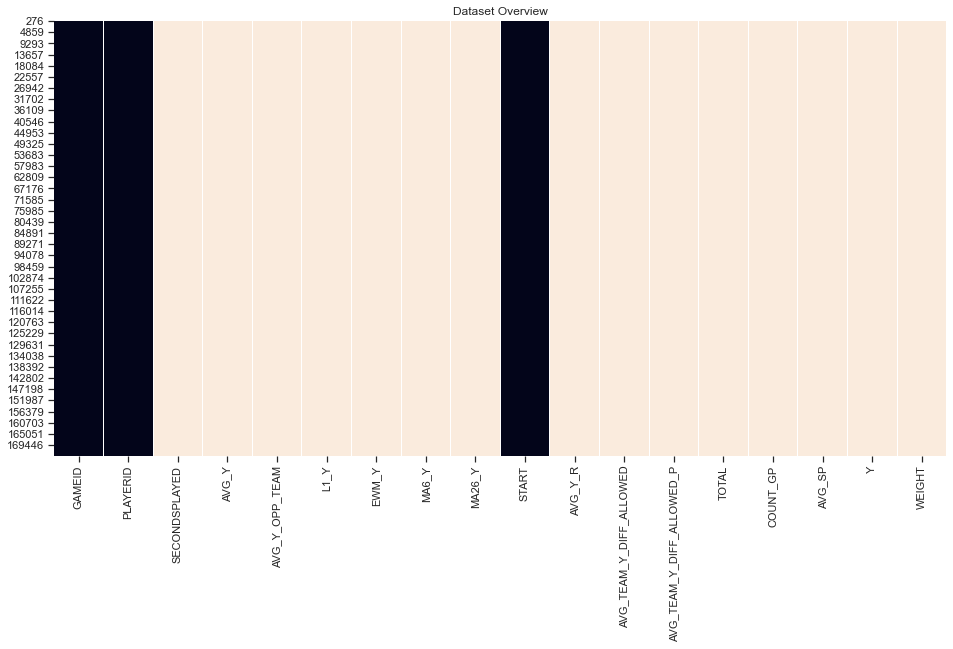

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [40]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [41]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            temp_feature_matrix = feature_matrix.copy()
            temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[numeric_regressors] = x_scaler.fit_transform(temp_feature_matrix[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[[y]] = y_scaler.fit_transform(temp_feature_matrix[[y]])

            # feature selection
            X = temp_feature_matrix[regressors]
            Y = temp_feature_matrix[y]
            W = temp_feature_matrix[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)

            X = temp_feature_matrix[selected_features].values
            Y = temp_feature_matrix[y].values
            W = temp_feature_matrix[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('\nModel:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_Y', 'AVG_Y_OPP_TEAM', 'EWM_Y', 'MA6_Y', 'MA26_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.0006330497771127396

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'MA6_Y', 'MA26_Y', 'START', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0006321247498009805

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_Y', 'AVG_Y_OPP_TEAM', 'EWM_Y', 'MA6_Y', 'MA26_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.0006330149556402778

Model: LinearRegression()
Transformer: Log
Scale: True
Selected Features: ['AVG_Y', 'MA6_Y', 'MA26_Y', 'START', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0006321949927678466

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_byl

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [42]:
selected_features = ['AVG_Y', 'EWM_Y', 'AVG_Y_R', 'MA26_Y', 'AVG_TEAM_Y_DIFF_ALLOWED',
                     'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [43]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0006790	test: 0.0007782	best: 0.0007782 (0)	total: 11.1ms	remaining: 55.5s
1:	learn: 0.0006782	test: 0.0007775	best: 0.0007775 (1)	total: 21.8ms	remaining: 54.4s
2:	learn: 0.0006774	test: 0.0007768	best: 0.0007768 (2)	total: 31.4ms	remaining: 52.4s
3:	learn: 0.0006766	test: 0.0007761	best: 0.0007761 (3)	total: 39.6ms	remaining: 49.5s
4:	learn: 0.0006758	test: 0.0007754	best: 0.0007754 (4)	total: 49.2ms	remaining: 49.1s
5:	learn: 0.0006751	test: 0.0007747	best: 0.0007747 (5)	total: 57.7ms	remaining: 48s
6:	learn: 0.0006744	test: 0.0007740	best: 0.0007740 (6)	total: 66ms	remaining: 47.1s
7:	learn: 0.0006736	test: 0.0007733	best: 0.0007733 (7)	total: 74.5ms	remaining: 46.5s
8:	learn: 0.0006729	test: 0.0007727	best: 0.0007727 (8)	total: 82.9ms	remaining: 46s
9:	learn: 0.0006723	test: 0.0007720	best: 0.0007720 (9)	total: 91.6ms	remaining: 45.7s
10:	learn: 0.0006716	test: 0.0007715	best: 0.0007715 (10)	total: 99.9ms	remaining: 45.3s
11:	learn: 0.0006709	test: 0.0007708	best: 0.00

111:	learn: 0.0006390	test: 0.0007407	best: 0.0007407 (111)	total: 1.01s	remaining: 44.3s
112:	learn: 0.0006388	test: 0.0007406	best: 0.0007406 (112)	total: 1.03s	remaining: 44.4s
113:	learn: 0.0006387	test: 0.0007405	best: 0.0007405 (113)	total: 1.03s	remaining: 44.4s
114:	learn: 0.0006386	test: 0.0007403	best: 0.0007403 (114)	total: 1.04s	remaining: 44.3s
115:	learn: 0.0006385	test: 0.0007402	best: 0.0007402 (115)	total: 1.05s	remaining: 44.3s
116:	learn: 0.0006383	test: 0.0007401	best: 0.0007401 (116)	total: 1.06s	remaining: 44.3s
117:	learn: 0.0006382	test: 0.0007400	best: 0.0007400 (117)	total: 1.07s	remaining: 44.2s
118:	learn: 0.0006381	test: 0.0007399	best: 0.0007399 (118)	total: 1.08s	remaining: 44.2s
119:	learn: 0.0006380	test: 0.0007398	best: 0.0007398 (119)	total: 1.09s	remaining: 44.2s
120:	learn: 0.0006379	test: 0.0007397	best: 0.0007397 (120)	total: 1.1s	remaining: 44.3s
121:	learn: 0.0006378	test: 0.0007395	best: 0.0007395 (121)	total: 1.11s	remaining: 44.2s
122:	learn:

224:	learn: 0.0006314	test: 0.0007331	best: 0.0007331 (224)	total: 2.01s	remaining: 42.7s
225:	learn: 0.0006314	test: 0.0007331	best: 0.0007331 (225)	total: 2.03s	remaining: 42.8s
226:	learn: 0.0006314	test: 0.0007330	best: 0.0007330 (226)	total: 2.04s	remaining: 42.8s
227:	learn: 0.0006313	test: 0.0007330	best: 0.0007330 (227)	total: 2.04s	remaining: 42.8s
228:	learn: 0.0006313	test: 0.0007330	best: 0.0007330 (228)	total: 2.05s	remaining: 42.8s
229:	learn: 0.0006313	test: 0.0007330	best: 0.0007330 (229)	total: 2.06s	remaining: 42.7s
230:	learn: 0.0006313	test: 0.0007329	best: 0.0007329 (230)	total: 2.07s	remaining: 42.7s
231:	learn: 0.0006312	test: 0.0007329	best: 0.0007329 (231)	total: 2.08s	remaining: 42.7s
232:	learn: 0.0006312	test: 0.0007329	best: 0.0007329 (232)	total: 2.09s	remaining: 42.7s
233:	learn: 0.0006312	test: 0.0007328	best: 0.0007328 (233)	total: 2.09s	remaining: 42.6s
234:	learn: 0.0006312	test: 0.0007328	best: 0.0007328 (234)	total: 2.1s	remaining: 42.6s
235:	learn:

337:	learn: 0.0006294	test: 0.0007308	best: 0.0007308 (337)	total: 3s	remaining: 41.5s
338:	learn: 0.0006293	test: 0.0007308	best: 0.0007308 (338)	total: 3.02s	remaining: 41.5s
339:	learn: 0.0006293	test: 0.0007308	best: 0.0007308 (339)	total: 3.02s	remaining: 41.5s
340:	learn: 0.0006293	test: 0.0007308	best: 0.0007308 (340)	total: 3.03s	remaining: 41.4s
341:	learn: 0.0006293	test: 0.0007308	best: 0.0007308 (341)	total: 3.04s	remaining: 41.4s
342:	learn: 0.0006293	test: 0.0007308	best: 0.0007308 (342)	total: 3.05s	remaining: 41.4s
343:	learn: 0.0006293	test: 0.0007307	best: 0.0007307 (343)	total: 3.06s	remaining: 41.4s
344:	learn: 0.0006293	test: 0.0007307	best: 0.0007307 (344)	total: 3.07s	remaining: 41.4s
345:	learn: 0.0006293	test: 0.0007307	best: 0.0007307 (345)	total: 3.08s	remaining: 41.4s
346:	learn: 0.0006293	test: 0.0007307	best: 0.0007307 (346)	total: 3.08s	remaining: 41.4s
347:	learn: 0.0006293	test: 0.0007307	best: 0.0007307 (347)	total: 3.09s	remaining: 41.3s
348:	learn: 0

432:	learn: 0.0006286	test: 0.0007300	best: 0.0007300 (432)	total: 3.81s	remaining: 40.2s
433:	learn: 0.0006286	test: 0.0007300	best: 0.0007300 (433)	total: 3.82s	remaining: 40.2s
434:	learn: 0.0006286	test: 0.0007300	best: 0.0007300 (434)	total: 3.83s	remaining: 40.2s
435:	learn: 0.0006286	test: 0.0007300	best: 0.0007300 (435)	total: 3.84s	remaining: 40.2s
436:	learn: 0.0006285	test: 0.0007300	best: 0.0007300 (436)	total: 3.85s	remaining: 40.2s
437:	learn: 0.0006285	test: 0.0007300	best: 0.0007300 (437)	total: 3.85s	remaining: 40.1s
438:	learn: 0.0006285	test: 0.0007300	best: 0.0007300 (438)	total: 3.86s	remaining: 40.1s
439:	learn: 0.0006285	test: 0.0007300	best: 0.0007300 (439)	total: 3.87s	remaining: 40.1s
440:	learn: 0.0006285	test: 0.0007300	best: 0.0007300 (440)	total: 3.88s	remaining: 40.1s
441:	learn: 0.0006285	test: 0.0007300	best: 0.0007300 (441)	total: 3.89s	remaining: 40.1s
442:	learn: 0.0006285	test: 0.0007299	best: 0.0007299 (442)	total: 3.9s	remaining: 40.1s
443:	learn:

525:	learn: 0.0006281	test: 0.0007296	best: 0.0007296 (525)	total: 4.61s	remaining: 39.2s
526:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (525)	total: 4.62s	remaining: 39.2s
527:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (527)	total: 4.63s	remaining: 39.2s
528:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (528)	total: 4.63s	remaining: 39.2s
529:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (529)	total: 4.64s	remaining: 39.2s
530:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (530)	total: 4.65s	remaining: 39.1s
531:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (531)	total: 4.66s	remaining: 39.1s
532:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (531)	total: 4.67s	remaining: 39.1s
533:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (533)	total: 4.68s	remaining: 39.1s
534:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (534)	total: 4.68s	remaining: 39.1s
535:	learn: 0.0006280	test: 0.0007296	best: 0.0007296 (535)	total: 4.69s	remaining: 39.1s
536:	learn

640:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (638)	total: 5.61s	remaining: 38.1s
641:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (638)	total: 5.62s	remaining: 38.1s
642:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (642)	total: 5.63s	remaining: 38.1s
643:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.63s	remaining: 38.1s
644:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.64s	remaining: 38.1s
645:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.65s	remaining: 38.1s
646:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.66s	remaining: 38.1s
647:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.67s	remaining: 38s
648:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.67s	remaining: 38s
649:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.68s	remaining: 38s
650:	learn: 0.0006275	test: 0.0007294	best: 0.0007294 (643)	total: 5.69s	remaining: 38s
651:	learn: 0.0006

737:	learn: 0.0006272	test: 0.0007293	best: 0.0007293 (737)	total: 6.41s	remaining: 37s
738:	learn: 0.0006271	test: 0.0007293	best: 0.0007293 (737)	total: 6.41s	remaining: 37s
739:	learn: 0.0006271	test: 0.0007293	best: 0.0007293 (737)	total: 6.42s	remaining: 37s
740:	learn: 0.0006271	test: 0.0007293	best: 0.0007293 (737)	total: 6.43s	remaining: 37s
741:	learn: 0.0006271	test: 0.0007293	best: 0.0007293 (737)	total: 6.44s	remaining: 37s
742:	learn: 0.0006271	test: 0.0007293	best: 0.0007293 (742)	total: 6.45s	remaining: 36.9s
743:	learn: 0.0006271	test: 0.0007292	best: 0.0007292 (743)	total: 6.46s	remaining: 36.9s
744:	learn: 0.0006271	test: 0.0007292	best: 0.0007292 (744)	total: 6.46s	remaining: 36.9s
745:	learn: 0.0006271	test: 0.0007292	best: 0.0007292 (745)	total: 6.47s	remaining: 36.9s
746:	learn: 0.0006271	test: 0.0007292	best: 0.0007292 (745)	total: 6.48s	remaining: 36.9s
747:	learn: 0.0006271	test: 0.0007292	best: 0.0007292 (745)	total: 6.49s	remaining: 36.9s
748:	learn: 0.000627

836:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (836)	total: 7.21s	remaining: 35.8s
837:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (837)	total: 7.21s	remaining: 35.8s
838:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (838)	total: 7.22s	remaining: 35.8s
839:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (839)	total: 7.23s	remaining: 35.8s
840:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (839)	total: 7.24s	remaining: 35.8s
841:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (839)	total: 7.25s	remaining: 35.8s
842:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (839)	total: 7.25s	remaining: 35.8s
843:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (839)	total: 7.27s	remaining: 35.8s
844:	learn: 0.0006268	test: 0.0007292	best: 0.0007292 (839)	total: 7.28s	remaining: 35.8s
845:	learn: 0.0006267	test: 0.0007292	best: 0.0007292 (839)	total: 7.29s	remaining: 35.8s
846:	learn: 0.0006267	test: 0.0007292	best: 0.0007292 (839)	total: 7.3s	remaining: 35.8s
847:	learn:

# Evaluation
Lastly, I will evaluate the final model.

In [44]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0006790	test: 0.0006760	best: 0.0006760 (0)	total: 10.9ms	remaining: 54.5s
1:	learn: 0.0006782	test: 0.0006752	best: 0.0006752 (1)	total: 19.5ms	remaining: 48.7s
2:	learn: 0.0006774	test: 0.0006744	best: 0.0006744 (2)	total: 28ms	remaining: 46.6s
3:	learn: 0.0006766	test: 0.0006736	best: 0.0006736 (3)	total: 36.1ms	remaining: 45s
4:	learn: 0.0006758	test: 0.0006728	best: 0.0006728 (4)	total: 44.4ms	remaining: 44.4s
5:	learn: 0.0006751	test: 0.0006720	best: 0.0006720 (5)	total: 52.7ms	remaining: 43.9s
6:	learn: 0.0006744	test: 0.0006713	best: 0.0006713 (6)	total: 60.6ms	remaining: 43.2s
7:	learn: 0.0006736	test: 0.0006705	best: 0.0006705 (7)	total: 69.5ms	remaining: 43.4s
8:	learn: 0.0006729	test: 0.0006698	best: 0.0006698 (8)	total: 77.8ms	remaining: 43.2s
9:	learn: 0.0006723	test: 0.0006691	best: 0.0006691 (9)	total: 85.7ms	remaining: 42.8s
10:	learn: 0.0006716	test: 0.0006684	best: 0.0006684 (10)	total: 93.7ms	remaining: 42.5s
11:	learn: 0.0006709	test: 0.0006677	best: 0.

113:	learn: 0.0006387	test: 0.0006343	best: 0.0006343 (113)	total: 1.01s	remaining: 43.4s
114:	learn: 0.0006386	test: 0.0006342	best: 0.0006342 (114)	total: 1.02s	remaining: 43.5s
115:	learn: 0.0006385	test: 0.0006340	best: 0.0006340 (115)	total: 1.03s	remaining: 43.4s
116:	learn: 0.0006383	test: 0.0006339	best: 0.0006339 (116)	total: 1.04s	remaining: 43.4s
117:	learn: 0.0006382	test: 0.0006338	best: 0.0006338 (117)	total: 1.05s	remaining: 43.4s
118:	learn: 0.0006381	test: 0.0006337	best: 0.0006337 (118)	total: 1.05s	remaining: 43.3s
119:	learn: 0.0006380	test: 0.0006335	best: 0.0006335 (119)	total: 1.06s	remaining: 43.3s
120:	learn: 0.0006379	test: 0.0006334	best: 0.0006334 (120)	total: 1.07s	remaining: 43.2s
121:	learn: 0.0006378	test: 0.0006333	best: 0.0006333 (121)	total: 1.08s	remaining: 43.2s
122:	learn: 0.0006377	test: 0.0006332	best: 0.0006332 (122)	total: 1.09s	remaining: 43.1s
123:	learn: 0.0006375	test: 0.0006331	best: 0.0006331 (123)	total: 1.1s	remaining: 43.1s
124:	learn:

207:	learn: 0.0006320	test: 0.0006274	best: 0.0006274 (207)	total: 1.81s	remaining: 41.6s
208:	learn: 0.0006320	test: 0.0006274	best: 0.0006274 (208)	total: 1.81s	remaining: 41.6s
209:	learn: 0.0006319	test: 0.0006274	best: 0.0006274 (209)	total: 1.82s	remaining: 41.6s
210:	learn: 0.0006319	test: 0.0006273	best: 0.0006273 (210)	total: 1.83s	remaining: 41.6s
211:	learn: 0.0006319	test: 0.0006273	best: 0.0006273 (211)	total: 1.84s	remaining: 41.6s
212:	learn: 0.0006318	test: 0.0006273	best: 0.0006273 (212)	total: 1.85s	remaining: 41.5s
213:	learn: 0.0006318	test: 0.0006272	best: 0.0006272 (213)	total: 1.86s	remaining: 41.5s
214:	learn: 0.0006318	test: 0.0006272	best: 0.0006272 (214)	total: 1.86s	remaining: 41.5s
215:	learn: 0.0006317	test: 0.0006272	best: 0.0006272 (215)	total: 1.87s	remaining: 41.4s
216:	learn: 0.0006317	test: 0.0006271	best: 0.0006271 (216)	total: 1.88s	remaining: 41.4s
217:	learn: 0.0006317	test: 0.0006271	best: 0.0006271 (217)	total: 1.89s	remaining: 41.4s
218:	learn

304:	learn: 0.0006298	test: 0.0006254	best: 0.0006254 (304)	total: 2.61s	remaining: 40.3s
305:	learn: 0.0006298	test: 0.0006254	best: 0.0006254 (305)	total: 2.62s	remaining: 40.2s
306:	learn: 0.0006297	test: 0.0006254	best: 0.0006254 (306)	total: 2.63s	remaining: 40.2s
307:	learn: 0.0006297	test: 0.0006254	best: 0.0006254 (307)	total: 2.64s	remaining: 40.2s
308:	learn: 0.0006297	test: 0.0006253	best: 0.0006253 (308)	total: 2.65s	remaining: 40.2s
309:	learn: 0.0006297	test: 0.0006253	best: 0.0006253 (309)	total: 2.65s	remaining: 40.2s
310:	learn: 0.0006297	test: 0.0006253	best: 0.0006253 (310)	total: 2.66s	remaining: 40.1s
311:	learn: 0.0006297	test: 0.0006253	best: 0.0006253 (311)	total: 2.67s	remaining: 40.1s
312:	learn: 0.0006297	test: 0.0006253	best: 0.0006253 (312)	total: 2.68s	remaining: 40.1s
313:	learn: 0.0006297	test: 0.0006253	best: 0.0006253 (313)	total: 2.69s	remaining: 40.1s
314:	learn: 0.0006296	test: 0.0006253	best: 0.0006253 (314)	total: 2.69s	remaining: 40.1s
315:	learn

403:	learn: 0.0006288	test: 0.0006247	best: 0.0006247 (403)	total: 3.41s	remaining: 38.8s
404:	learn: 0.0006288	test: 0.0006247	best: 0.0006247 (404)	total: 3.42s	remaining: 38.8s
405:	learn: 0.0006288	test: 0.0006247	best: 0.0006247 (405)	total: 3.42s	remaining: 38.8s
406:	learn: 0.0006288	test: 0.0006247	best: 0.0006247 (406)	total: 3.43s	remaining: 38.8s
407:	learn: 0.0006287	test: 0.0006247	best: 0.0006247 (407)	total: 3.44s	remaining: 38.7s
408:	learn: 0.0006287	test: 0.0006247	best: 0.0006247 (408)	total: 3.45s	remaining: 38.7s
409:	learn: 0.0006287	test: 0.0006247	best: 0.0006247 (409)	total: 3.46s	remaining: 38.7s
410:	learn: 0.0006287	test: 0.0006247	best: 0.0006247 (410)	total: 3.46s	remaining: 38.7s
411:	learn: 0.0006287	test: 0.0006246	best: 0.0006246 (411)	total: 3.47s	remaining: 38.7s
412:	learn: 0.0006287	test: 0.0006246	best: 0.0006246 (412)	total: 3.48s	remaining: 38.6s
413:	learn: 0.0006287	test: 0.0006246	best: 0.0006246 (413)	total: 3.49s	remaining: 38.6s
414:	learn

502:	learn: 0.0006282	test: 0.0006244	best: 0.0006244 (502)	total: 4.2s	remaining: 37.6s
503:	learn: 0.0006282	test: 0.0006244	best: 0.0006244 (503)	total: 4.21s	remaining: 37.5s
504:	learn: 0.0006282	test: 0.0006244	best: 0.0006244 (504)	total: 4.22s	remaining: 37.5s
505:	learn: 0.0006282	test: 0.0006244	best: 0.0006244 (505)	total: 4.22s	remaining: 37.5s
506:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (506)	total: 4.23s	remaining: 37.5s
507:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (507)	total: 4.24s	remaining: 37.5s
508:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (508)	total: 4.25s	remaining: 37.5s
509:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (509)	total: 4.26s	remaining: 37.5s
510:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (510)	total: 4.26s	remaining: 37.5s
511:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (511)	total: 4.27s	remaining: 37.4s
512:	learn: 0.0006281	test: 0.0006244	best: 0.0006244 (512)	total: 4.28s	remaining: 37.4s
513:	learn:

601:	learn: 0.0006277	test: 0.0006243	best: 0.0006243 (601)	total: 4.99s	remaining: 36.5s
602:	learn: 0.0006277	test: 0.0006243	best: 0.0006243 (602)	total: 5s	remaining: 36.5s
603:	learn: 0.0006277	test: 0.0006243	best: 0.0006243 (603)	total: 5.01s	remaining: 36.5s
604:	learn: 0.0006277	test: 0.0006243	best: 0.0006243 (604)	total: 5.02s	remaining: 36.5s
605:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (605)	total: 5.03s	remaining: 36.5s
606:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (606)	total: 5.03s	remaining: 36.4s
607:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (607)	total: 5.04s	remaining: 36.4s
608:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (608)	total: 5.05s	remaining: 36.4s
609:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (609)	total: 5.06s	remaining: 36.4s
610:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (610)	total: 5.06s	remaining: 36.4s
611:	learn: 0.0006277	test: 0.0006242	best: 0.0006242 (611)	total: 5.07s	remaining: 36.4s
612:	learn: 0

698:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.79s	remaining: 35.6s
699:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.79s	remaining: 35.6s
700:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.8s	remaining: 35.6s
701:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.81s	remaining: 35.6s
702:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.82s	remaining: 35.6s
703:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.83s	remaining: 35.6s
704:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.83s	remaining: 35.5s
705:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (698)	total: 5.84s	remaining: 35.5s
706:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (706)	total: 5.85s	remaining: 35.5s
707:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (707)	total: 5.86s	remaining: 35.5s
708:	learn: 0.0006273	test: 0.0006242	best: 0.0006242 (707)	total: 5.86s	remaining: 35.5s
709:	learn:

799:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (798)	total: 6.59s	remaining: 34.6s
800:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (798)	total: 6.59s	remaining: 34.6s
801:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (798)	total: 6.6s	remaining: 34.6s
802:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (802)	total: 6.61s	remaining: 34.6s
803:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (803)	total: 6.62s	remaining: 34.5s
804:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (804)	total: 6.63s	remaining: 34.5s
805:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (804)	total: 6.63s	remaining: 34.5s
806:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (806)	total: 6.64s	remaining: 34.5s
807:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (806)	total: 6.65s	remaining: 34.5s
808:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (808)	total: 6.66s	remaining: 34.5s
809:	learn: 0.0006269	test: 0.0006241	best: 0.0006241 (808)	total: 6.67s	remaining: 34.5s
810:	learn:

899:	learn: 0.0006266	test: 0.0006241	best: 0.0006241 (886)	total: 7.38s	remaining: 33.6s
900:	learn: 0.0006266	test: 0.0006241	best: 0.0006241 (886)	total: 7.38s	remaining: 33.6s
901:	learn: 0.0006266	test: 0.0006241	best: 0.0006241 (886)	total: 7.39s	remaining: 33.6s
902:	learn: 0.0006266	test: 0.0006241	best: 0.0006241 (886)	total: 7.41s	remaining: 33.6s
903:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (886)	total: 7.42s	remaining: 33.6s
904:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (904)	total: 7.42s	remaining: 33.6s
905:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (904)	total: 7.43s	remaining: 33.6s
906:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (904)	total: 7.44s	remaining: 33.6s
907:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (904)	total: 7.45s	remaining: 33.6s
908:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (904)	total: 7.46s	remaining: 33.6s
909:	learn: 0.0006265	test: 0.0006241	best: 0.0006241 (904)	total: 7.46s	remaining: 33.5s
910:	learn

First, I will visualize the feature importances.

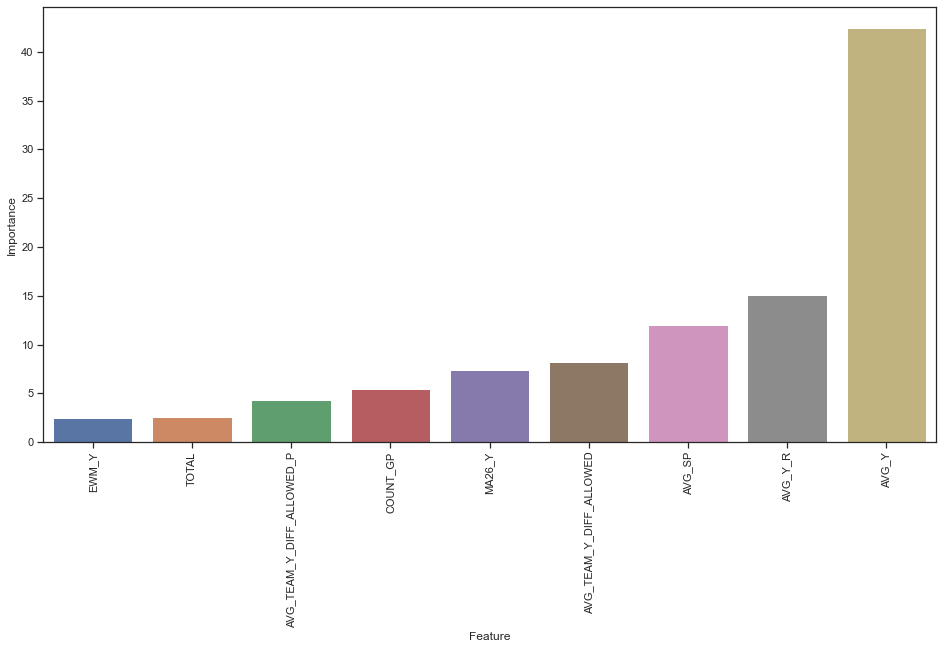

In [45]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [46]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.133
Baseline: 0.104

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.000625
Baseline: 0.000635

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.000809
Baseline: 0.000823


Residual analysis:

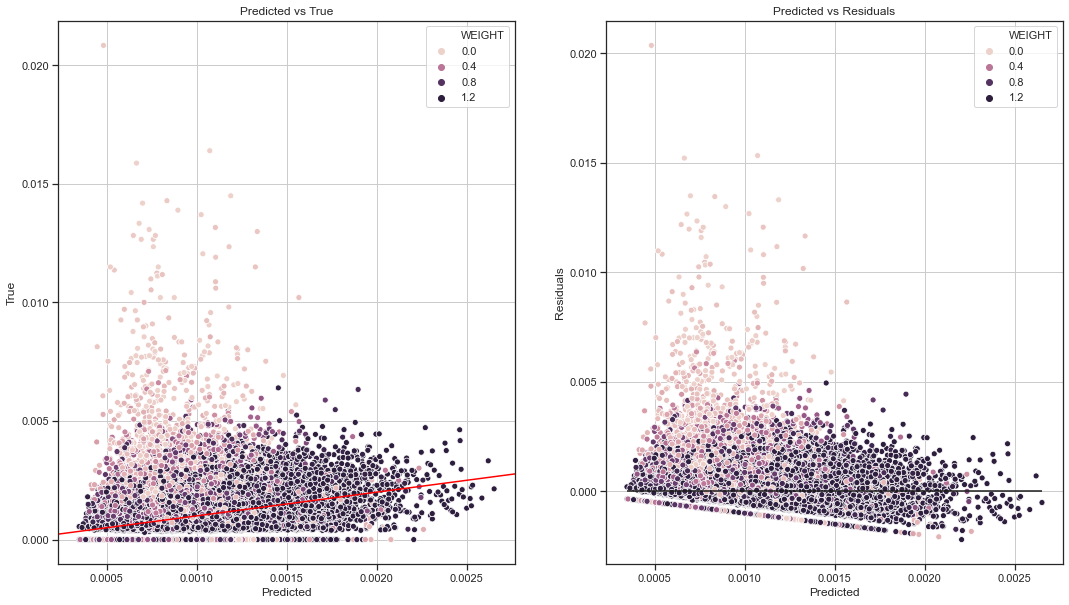

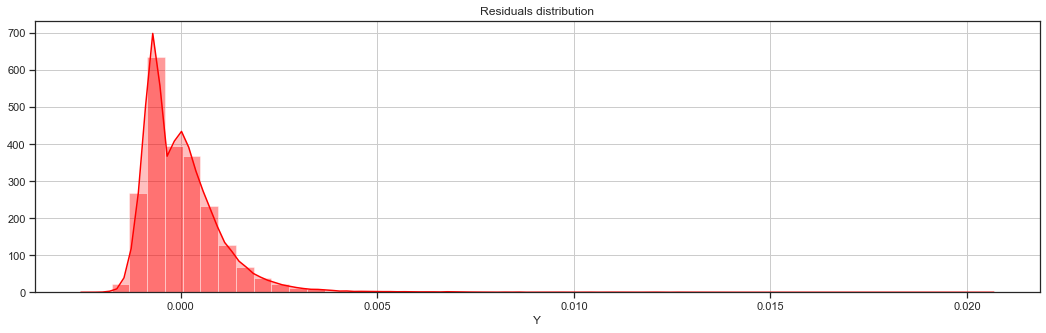

In [47]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [48]:
stat, p = shapiro(residuals)
print(stat, p)

0.8018264174461365 0.0


Residuals are normally distributed and not heteroskedastic.